<a href="https://colab.research.google.com/github/samyzaf/kerutils/blob/master/figtab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<IMG
src="https://samyzaf.com/ML/figtab/images/figtab2.png"
width="70%"
/>

* **FigTab** is a data set of 96x96x3 pixel images of geometrical shapes.
  Each image consists of a 3x3 grid of 9 simple geometrical figures
  (ellipse, triangle, quadrilateral).
  
* They were generated by an automatic Python script with randomization on shapes.
  See file figtab.py in https://samyzaf.com/kerutils.zip.
* We used 96x96x3 pixels images to make it possible for standard pc systems to run the
  exercises in this notebook (a good graphics card is required though).
* It is intended to serve as a simple and clean data set for preliminary excursions,
  tutorials, or course projects in deep learning courses.
* It is also intended to serve as a simple data set for
  benchmarking deep learning libraries and deep learning hardware (like GPU systems).
* The simplest recognition task related to such data set is for example to
  count the number of occurrences of a particular shape in each image.
* In this notebook we will try to build an efficient neural
  network for detecting the exact
  number of triangles in each image.
  We will therefore have 10 categories which we assign the following names:  
    0: 0-triangles  
    1: 1-triangles  
    2: 2-triangles  
    3: 3-triangles  
    4: 4-triangles  
    5: 5-triangles  
    6: 6-triangles  
    7: 7-triangles  
    8: 8-triangles  
    9: 9-triangles
* Some examples of this categories can be seen in the above diagram.
  Our neural network will accept a 96x96x3 pixel color image as input
  and will output the exact number of triangles this image has.
  
* One can think of other recognition tasks, such as detecting all images
  that have the same shape along one of the diagonals, or in one row, etc.
  It would be interesting to see if their solution requires the same effort
  or not? We propose these challenges as exercises and/or course projects
  for students in an introductory deep learning course.
  
* The **FigTab** data set consists of the following
  6 HDF5 files of 96x96 pixel color images:
  1. https://samyzaf.com/ML/figtab/train.h5.zip (20,000 images)
  2. https://samyzaf.com/ML/figtab/test.h5.zip (5,000 images)
  3. https://samyzaf.com/ML/figtab/figtab1.h5.zip (10,000 images)
  4. https://samyzaf.com/ML/figtab/figtab2.h5.zip (10,000 images)
  5. https://samyzaf.com/ML/figtab/figtab3.h5.zip (10,000 images)
  6. https://samyzaf.com/ML/figtab/figtab4.h5.zip (10,000 images)

* The first two items are used for training and validation.
  The "train.h5" contains 20,000 samples (2000 from each class),
  and the "test.h5" data set contains 5000 samples (500 from each class):
  1. http://www.samyzaf.com/ML/figtab/train.h5
  2. http://www.samyzaf.com/ML/figtab/test.h5

* The data set was verified to have no duplications using
  the **test_uniqueness** method in our **kerutils** package.
  
* We use the **h5py** Python package for manipulating HDF5 files.
  Handling HDF5 files can be easily learned from the following tutorial:
  https://www.getdatajoy.com/learn/Read_and_Write_HDF5_from_Python

## **Our kerutils package**
* Some Python utilities for manipulating these data sets can
  be found in our [**kerutils**](https://samyzaf.com/kerutils.zip)
  Python package.
* This package contains utilities for iterating over the images
  and graphs within each of the above HDF5 archives,
  and utilities for querying or manipulating graphs and trees.
  They are based on the Python **Networkx** package.
* We start by installing the **kerutils** package
  (and all the packages it depends on).

In [1]:
%pip install -q https://samyzaf.com/kerutils.zip
from kerutils import *
%matplotlib inline
print(f"Tensorflow version: {tf.version.VERSION}")

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
Tensorflow version: 2.18.0


In [2]:
class_name = {
    0: '0-triangles',
    1: '1-triangles',
    2: '2-triangles',
    3: '3-triangles',
    4: '4-triangles',
    5: '5-triangles',
    6: '6-triangles',
    7: '7-triangles',
    8: '8-triangles',
    9: '9-triangles',
}

num_classes = len(class_name)  # 10
classes = range(num_classes)
plt.rcParams['figure.figsize'] = 8,6
plt.rcParams['figure.dpi'] = 96
image_size = (96,96)

## **Load training and validation data sets**
* The
  [**imgutils**](http://www.samyzaf.com/cgi-bin/view_file.py?file=ML/lib/imgutils.py)
  module contains a utility **load_data**
  for loading HDF5 files to memory (as Numpy arrays).
* This method accepts the names of your training and validation
  data set files, and it returns the following six Numpy arrays:
  1. **X_train**: an array of 20000 images whose shape is 20000x96x96.
  2. **y_train**: a one dimensional array of 8000 integers
     representing the class of each image in **X_train**.
  3. **Y_train**: an 20000 array of **one-hot** vectors
     needed for a **Keras** model. For more details see:
  http://stackoverflow.com/questions/29831489/numpy-1-hot-array
  4. **X_test**: an array of 1000 validation images (1000x48x48)
  5. **y_test**: validation class array
  6. **Y_test**: one-hot vectors for the validation samples

* It should be noted that in additional to reading the images
  from the HDF5 file, the **load_data** method also performs
  some normalization of the image data like
  scaling it to a unit interval and centering it around
  the mean value.
* You can control these actions by tuning the options
  of this command. Please look at the source code to learn more.

In [3]:
download("https://samyzaf.com/ML/figtab/train.h5.zip", decompress=True)
download("https://samyzaf.com/ML/figtab/test.h5.zip", decompress=True)
X_train, y_train, Y_train, X_test, y_test, Y_test = load_data('train.h5', 'test.h5')

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'training samples')
print(X_test.shape[0], 'validation samples')

Downloaded train.h5.zip from https://samyzaf.com/ML/figtab/train.h5.zip
Extracting zip file train.h5.zip ...
Done.
Downloaded test.h5.zip from https://samyzaf.com/ML/figtab/test.h5.zip
Extracting zip file test.h5.zip ...
Done.
Loading training data set: train.h5
Total num images in file: 20000
Load progress: 100%   
Time: 17.54 seconds
Loading validation data set: test.h5
Total num images in file: 5000
Load progress: 100%   
Time: 4.07 seconds
20000 training samples
5000 validation samples
Image shape: (96, 96, 3)
X_train shape: (20000, 96, 96, 3)
20000 training samples
5000 validation samples


The original data of each image is a 48x48x3 matrix of integers from 0 to 255.
We need to scale it down to floats in the unit interval.
This done automatically by the above **load_data** method,
which applies the **data_normalization** procedure.
Look at the **imgutils** module for more details.

Let's also write two small utilities for drawing samples of images,
so we can inspect our results visually.
We need to pull our images from the HDF5 files and not from the **X_train** and **X_test** arrays,
since they were normalized and have significantly changed.
Here is a method for extracting image number i from an HDF5 file:

In [4]:
def get_img(hfile, i):
    f = h5py.File(hfile,'r')
    img = np.array(f.get('img_' + str(i)))
    cls = f.get('cls_' + str(i))[()]
    f.close()
    return img, cls

def draw_image(hfile, i):
    plt.figure(figsize=(3,3))
    img, cls = get_img(hfile, i)
    plt.imshow(img, cmap='jet')
    plt.title(class_name[cls], fontsize=15, fontweight='bold', y=1.05)
    plt.show()

Let's draw image 18 in the **X_train** array as example

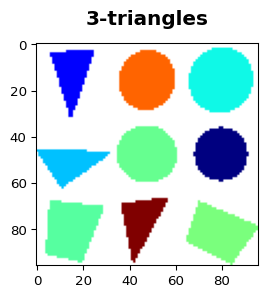

In [5]:
draw_image("train.h5", 18)

Sometimes we want to inspect a larger group of images in parallel, so we also provide a method
for drawing a grid of consecutive images.

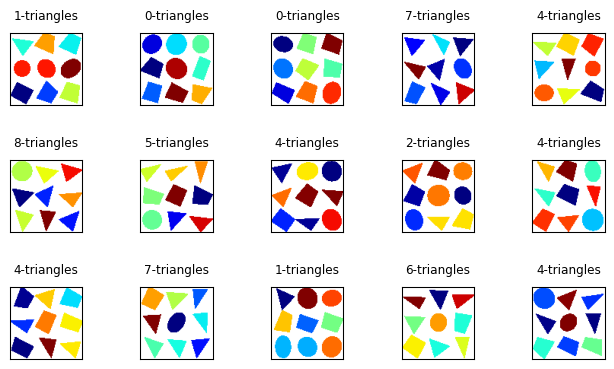

In [6]:
def draw_sample(hfile, n, rows=4, cols=4, imfile=None, fontsize=9, fontweight="normal", figsize=(8,5)):
    plt.figure(figsize=figsize)
    for i in range(0, rows*cols):
        ax = plt.subplot(rows, cols, i+1)
        img, cls = get_img(hfile, n+i+1)
        plt.imshow(img, cmap='jet')
        plt.title(class_name[cls], fontsize=fontsize, fontweight=fontweight, y=1.08)
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        plt.subplots_adjust(wspace=0.8, hspace=0.1)

draw_sample("train.h5", 400, 3, 5)

# **Building A Neural Network for FigTab**
* We will start with a legacy simple Keras model which combines
  one Convolution2D layer with two Dense layers.
  Although simple in terms of code, it is usually too expensive
  in terms of computation and hardware, and in general should be avoided.
* In general, **Dense layers** should be avoided as much
  as possible when dealing with image data.
  The general practice is to use **Convolution** and **Pooling** layers.
  These two types of layers are explained in more detail in the following two articles,
  which we recommend to read before you approach the following code:
  1. http://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf
  2. http://cs231n.github.io/convolutional-networks/

## **Model 1**
* We now define our first model for the recognizing **FigTab** shapes.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      33,554,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           2,570 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 10)                  │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,690,634 (128.52 MB)

 Trainable params: 33,690,634 (128.52 MB)

 Non-trainable params: 0 (0.00 B)

Model: "model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      33,554,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           2,570 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 10)                  │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,690,634 (128.52 MB)

 Trainable params: 33,690,634 (128.52 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.3895 - loss: 1.4876 - val_accuracy: 0.7390 - val_loss: 0.5856
Epoch 2/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.7043 - loss: 0.6875 - val_accuracy: 0.8662 - val_loss: 0.3762
Epoch 3/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.7871 - loss: 0.5183 - val_accuracy: 0.8868 - val_loss: 0.3104
Epoch 4/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.8240 - loss: 0.4287 - val_accuracy: 0.8352 - val_loss: 0.4011
Epoch 5/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.8471 - loss: 0.3828 - val_accuracy: 0.9130 - val_loss: 0.2306
Epoch 6/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.8724 - loss: 0.3280 - val_accuracy: 0.9166 - val_loss: 0.2235
Epoch 7/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.8836 - loss: 0.3075 - val_accuracy: 0.8774 - val_loss: 0.3092
Epoch 8/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9040 - loss: 

Saving model to: model_1.h5


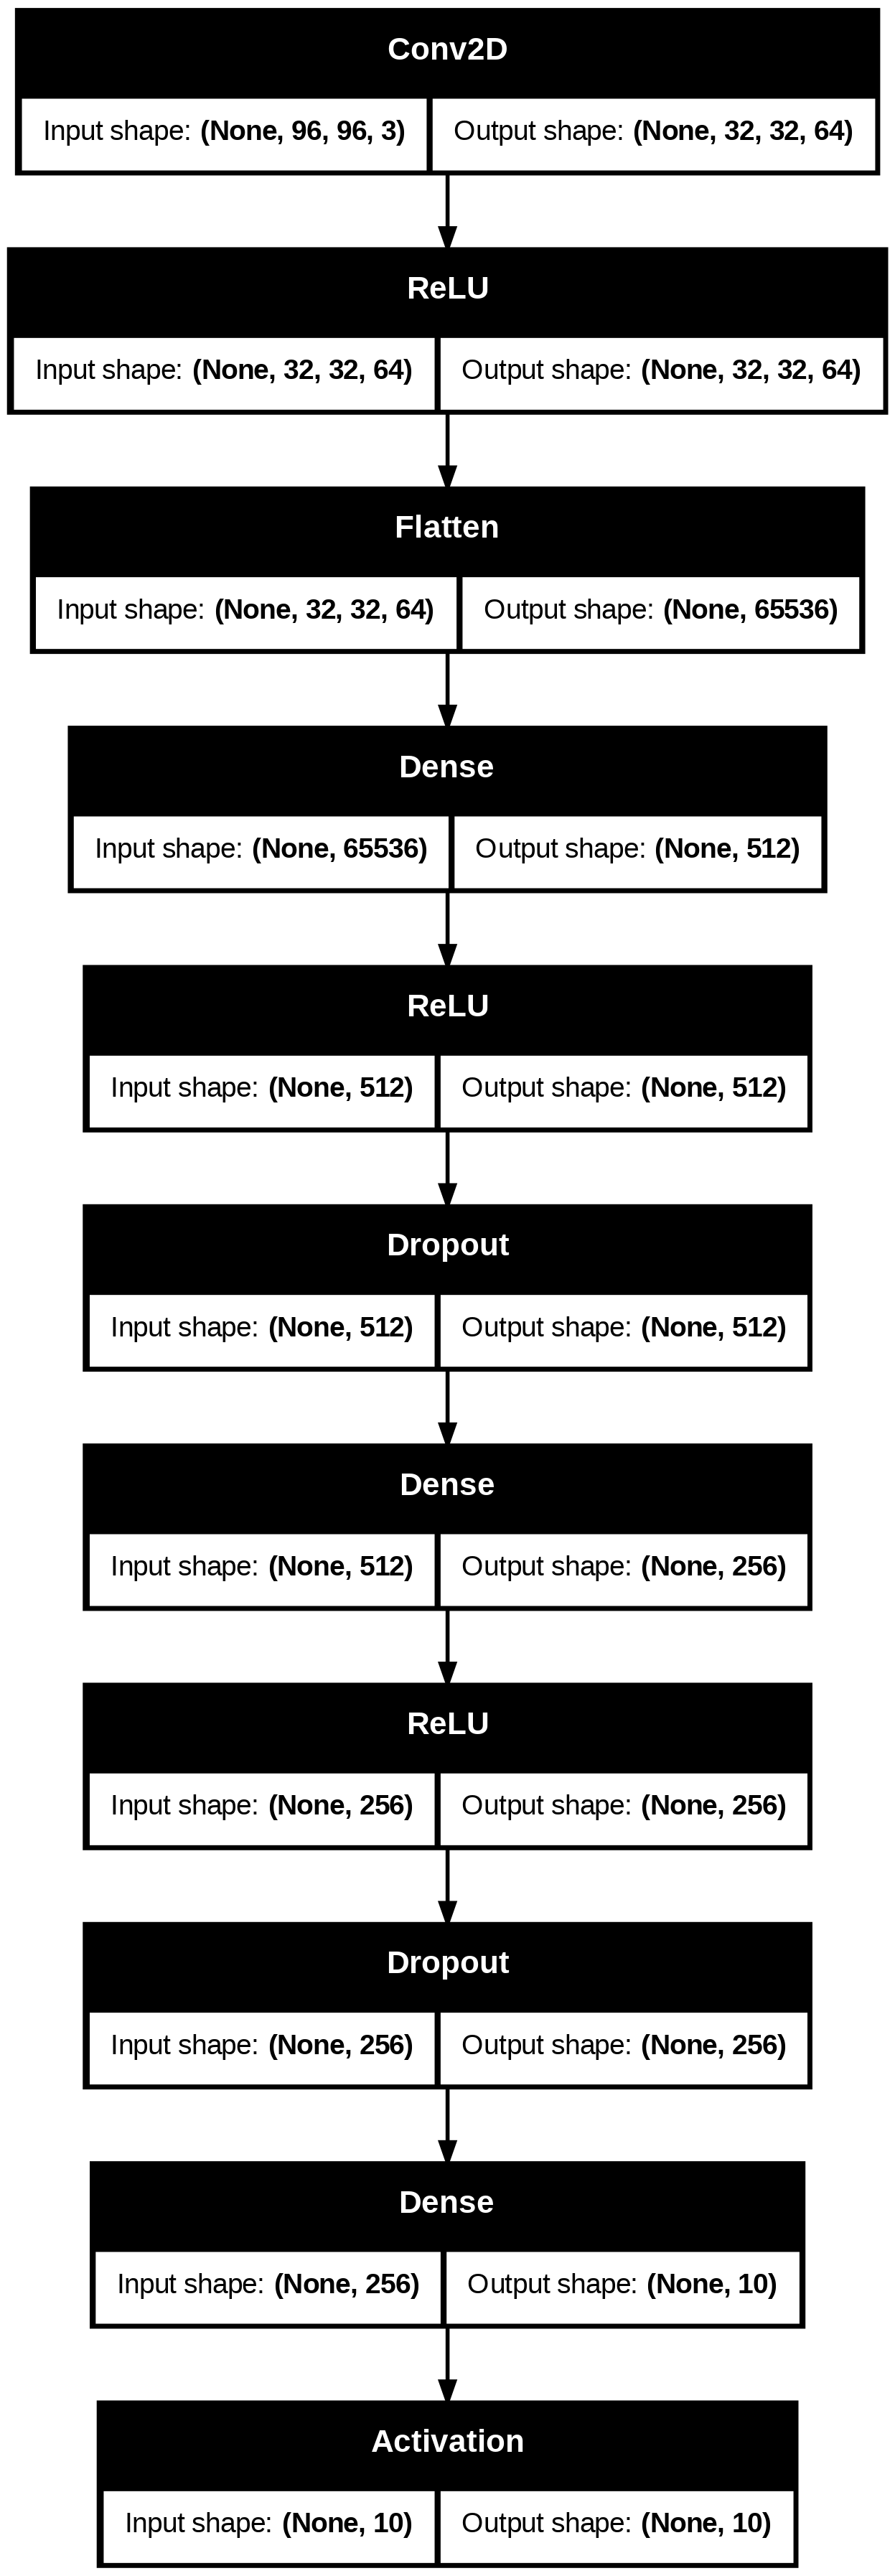

In [18]:
epochs = 100
#batch_size = 32
input_shape = X_train.shape[1:]

model = Sequential(name="model_1")
model.add(Conv2D(64, 3, 3, input_shape=input_shape))
model.add(ReLU())

model.add(Flatten())

model.add(Dense(512))
model.add(ReLU())
model.add(Dropout(0.4))

model.add(Dense(256))
model.add(ReLU())
model.add(Dropout(0.4))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

print(model.summary())
save_model_summary(model, "model_1_summary.txt")
write_file("model_1.json", model.to_json())
#fmon = FitMonitor(thresh=0.09, minacc=0.999, filename="model_1_autosave.h5")

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

hist = model.fit(
    X_train,
    Y_train,
    #batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_test, Y_test),
    verbose=True,
    #callbacks = [fmon]
)

model_file = "model_1.keras"
print("Saving model to:", model_file)
model.save(model_file)

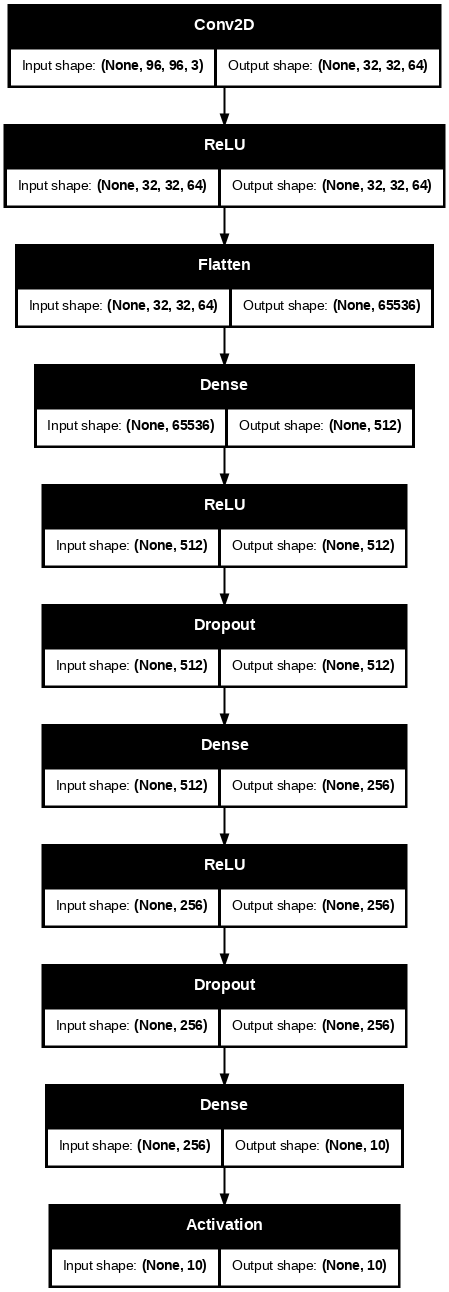

In [19]:
plot_model(model, to_file="model_1_scheme.png", show_layer_names=False, show_shapes=True, dpi=72)

Training: accuracy   = 0.999900 loss = 0.000788
Validation: accuracy = 0.919200 loss = 0.398424
Over fitting score   = 0.065664
Under fitting score  = 0.058150
Params count: 33690634
stop epoch = 99
epochs = 100


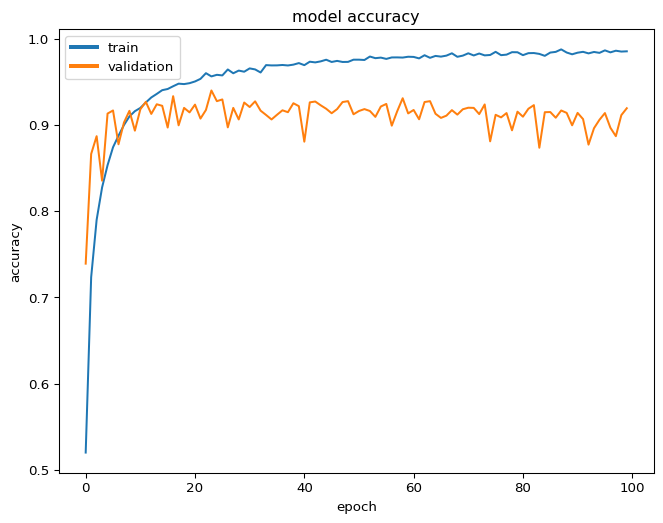

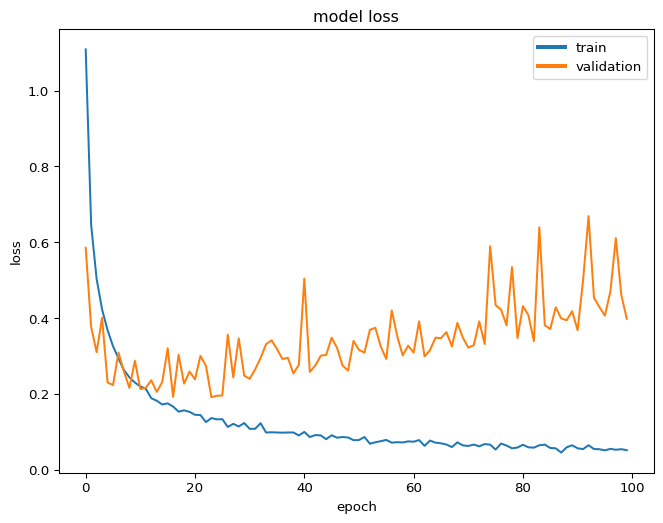

In [20]:
show_scores(model, hist, X_train, Y_train, X_test, Y_test)

### **Training Accuracy**

In [21]:
loss, accuracy = model.evaluate(X_train, Y_train, verbose=0)
print("Training: accuracy = %f  ;  loss = %f" % (accuracy, loss))

Training: accuracy = 0.999900  ;  loss = 0.000788


### **Validation Accuracy**

In [22]:
loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print("Validation: accuracy1 = %f  ;  loss1 = %f" % (accuracy, loss))

Validation: accuracy1 = 0.919200  ;  loss1 = 0.398424


* Although the training accuracy is quite high,
  the overall result is not good.
* The 10% gap with the validation accuracy is
  an indication of overfitting
  (which is also clearly noticeable from the accuracy and loss graphs above).
* Our model is successful on the training set only and
  is no as successful for other data.

## **Inspecting the output**

* Before we search for a new model, let's take a quick
  look on some of the cases that our model missed.
  It may give us clues on the strengths and weaknesses
  of NN models, and what we can expect
  from these artificial models.

* The **predict** method is helpful for
  getting a vector (**y_pred**)
  of the predicted classes of **model1**.
* We should compare **y_pred** to the expected true
  classes **y_test** in order to get
  the false cases:

In [24]:
x_pred = model.predict(X_test)
y_pred = np.argmax(x_pred, axis=1)

true_preds = [(x,y) for (x,y,p) in zip(X_test, y_test, y_pred) if y == p]
false_preds = [(x,y,p) for (x,y,p) in zip(X_test, y_test, y_pred) if y != p]
print("Number of valid predictions: ", len(true_preds))
print("Number of invalid predictions:", len(false_preds))

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Number of valid predictions:  4596
Number of invalid predictions: 404


* The array **false_preds** consists of all
  triples **(x,y,p)** where **x** is an image,
  **y** is its true class,
  and **p** is the false predicted value of our model.
  
* Lets visualize a sample of 15 items:

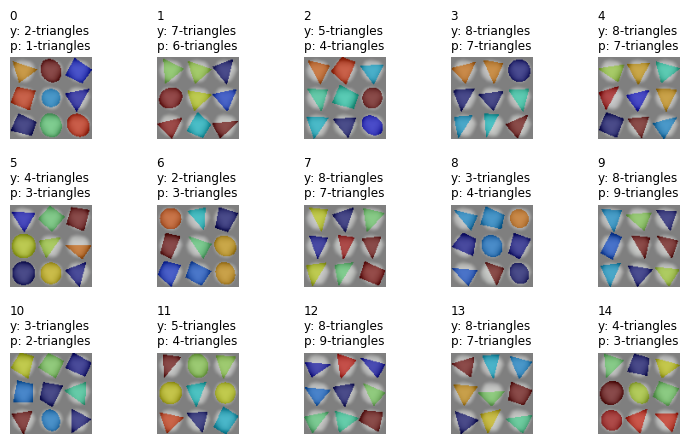

In [31]:
plt.figure(figsize=(9,6))
for i,(x,y,p) in enumerate(false_preds[0:15]):
    plt.subplot(3, 5, i+1)
    #plt.imshow(x, cmap='jet')
    plt.imshow(0.5*x + 0.5, cmap='jet')  # denormalize x from [-1,1] to [0,1]
    plt.title("%d\ny: %s\np: %s" % (i, class_name[y], class_name[p]), fontsize=9, loc='left')
    plt.axis('off')
    plt.subplots_adjust(wspace=0.8, hspace=0.0)

* We see that in all cases our model missed the correct answer by 1,
  which is almost like a human error.

## **Second Keras Model for FigTab database**
* Lets try to add an additional Convolution2D layer and
  reduce the width of the Dense layers.
* The number of parameters is still too high, but much less than model 1.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "model_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_3 (ReLU)                       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 10, 10, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_4 (ReLU)                       │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 6400)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │       1,638,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_5 (ReLU)                       │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_6 (ReLU)                       │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │             650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 10)                  │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,694,474 (6.46 MB)

 Trainable params: 1,694,474 (6.46 MB)

 Non-trainable params: 0 (0.00 B)

Model: "model_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_3 (ReLU)                       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 10, 10, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_4 (ReLU)                       │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 6400)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │       1,638,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_5 (ReLU)                       │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_6 (ReLU)                       │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │             650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 10)                  │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,694,474 (6.46 MB)

 Trainable params: 1,694,474 (6.46 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.3483 - loss: 1.5873 - val_accuracy: 0.8050 - val_loss: 0.5595
Epoch 2/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6772 - loss: 0.7394 - val_accuracy: 0.9248 - val_loss: 0.2912
Epoch 3/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7739 - loss: 0.5480 - val_accuracy: 0.9358 - val_loss: 0.2426
Epoch 4/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8169 - loss: 0.4516 - val_accuracy: 0.9466 - val_loss: 0.1877
Epoch 5/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8431 - loss: 0.3932 - val_accuracy: 0.8512 - val_loss: 0.3454
Epoch 6/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8750 - loss: 0.3250 - val_accuracy: 0.9736 - val_loss: 0.0936
Epoch 7/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8902 - loss: 0.2915 - val_accuracy: 0.9744 - val_loss: 0.0855
Epoch 8/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8988 - loss: 0.2763 - v

Saving model to: model_2.h5


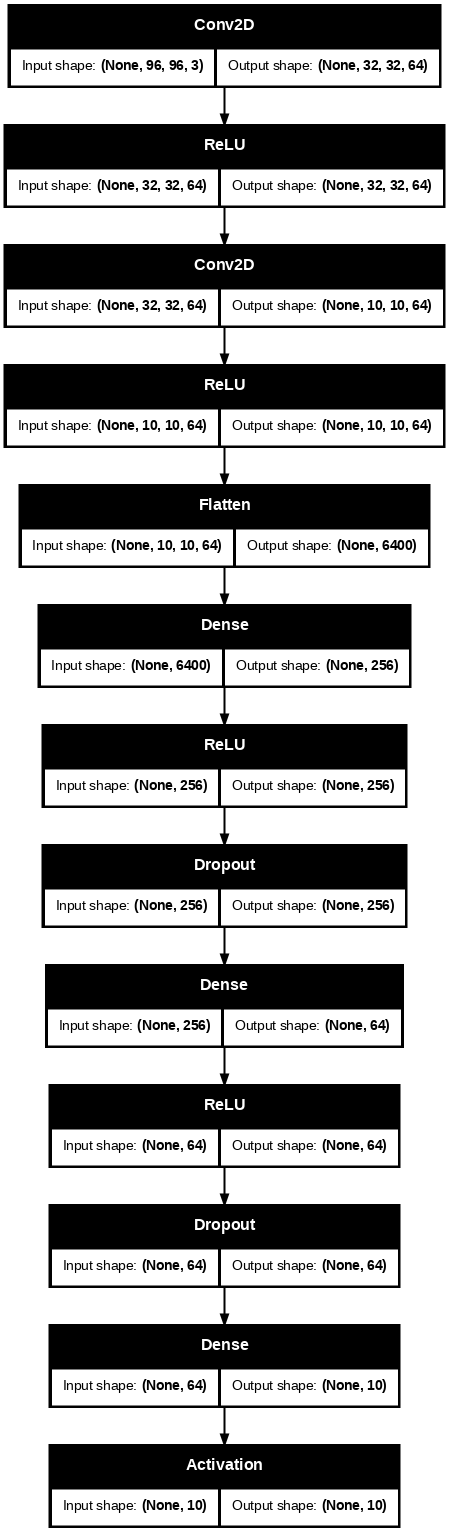

In [32]:
epochs = 100
batch_size = 32
input_shape = X_train.shape[1:]

model = Sequential(name="model_2")
model.add(Conv2D(64, 3, 3, input_shape=input_shape))
model.add(ReLU())

model.add(Conv2D(64, 3, 3, input_shape=input_shape))
model.add(ReLU())

model.add(Flatten())

model.add(Dense(256))
model.add(ReLU())
model.add(Dropout(0.4))

model.add(Dense(64))
model.add(ReLU())
model.add(Dropout(0.4))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

print(model.summary())
save_model_summary(model, "model_2_summary.txt")
write_file("model_2.json", model.to_json())
fmon = FitMonitor(thresh=0.09, minacc=0.999, filename="model_2_autosave.h5")

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

hist = model.fit(
    X_train,
    Y_train,
    #batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_test, Y_test),
    verbose=True,
    #callbacks = [fmon]
)

model_file = "model_2.h5"
print("Saving model to:", model_file)
model.save(model_file)
plot_model(model, to_file="model_2_scheme.png", show_layer_names=False, show_shapes=True, dpi=72)

Training: accuracy   = 0.998400 loss = 0.004681
Validation: accuracy = 0.983000 loss = 0.055764
Over fitting score   = 0.010701
Under fitting score  = 0.024421
Params count: 1694474
stop epoch = 99
epochs = 100


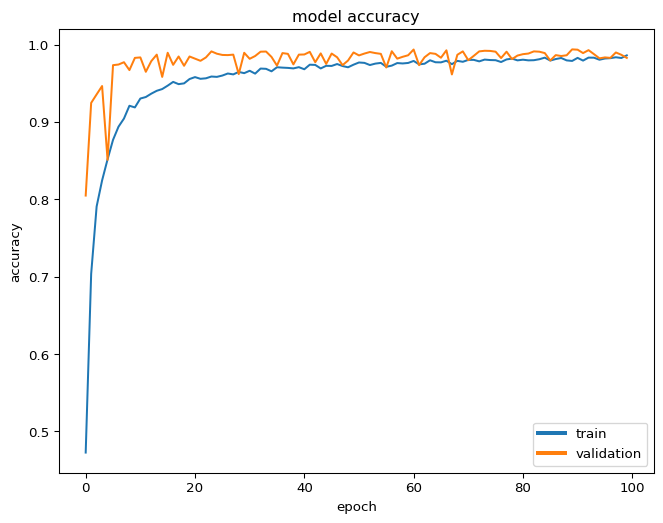

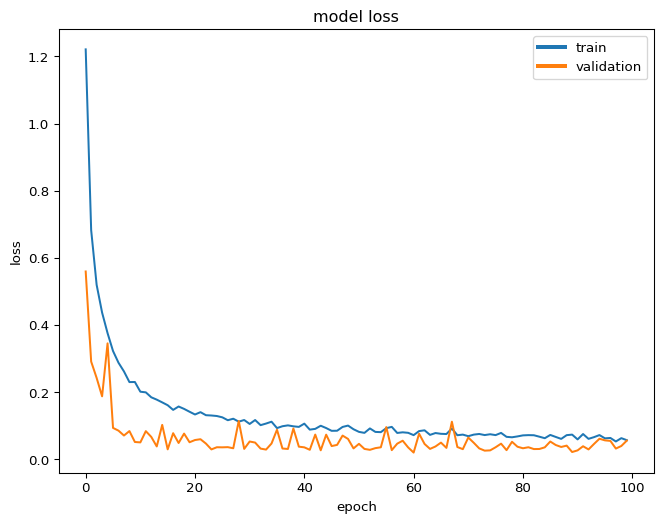

In [33]:
show_scores(model, hist, X_train, Y_train, X_test, Y_test)

### **Training Accuracy**

In [34]:
loss, accuracy = model.evaluate(X_train, Y_train, verbose=0)
print("Training: accuracy = %f  ;  loss = %f" % (accuracy, loss))

Training: accuracy = 0.998400  ;  loss = 0.004681


### **Validation Accuracy**

In [35]:
loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print("Validation: accuracy1 = %f  ;  loss1 = %f" % (accuracy, loss))

Validation: accuracy1 = 0.983000  ;  loss1 = 0.055764


* Adding more Convolution layers has reduced overfitting
  from 10% to less than 2%!
* But this is not good enough yet.
  The gap between the training and validation loss graph
  indicates that there's more room for improvement.

## **Validation credibility**
* Before proceeding to our third model, let's take a moment
  for discussing one more issue.
* From the two models we learn that training accuracy can be
  quite high, but we should not be impressed as we fall short
  in our validation sets.
* In some cases however we might be satisfied with what we
  got but would like to carry out further tests to make sure
  that the validation accuracy we have is not volatile.
* After all our validation set ("test.h5") has only
  5000 samples, which might not be enough to trust our model.
* Our **[imgutils](https://samyzaf.com/kerutils.zip)**
  module contains a special method **check_data_set**
  for testing our model on as many samples as we wish
  from our large repository of samples (~60K samples).
* This method accepts three arguments:
  1. Keras model object
  2. HDF5 file of FigTab images
  3. Number of images to sample (optional, defaults to all)
* You may want to sample a few thousand images
  from each repository in order to gain
  confidence in your model.
* Here are two examples of using this method
  which show that the validation accuracy we got
  is trustable:

In [11]:
download("https://samyzaf.com/ML/figtab/figtab1.h5.zip", decompress=True)
download("https://samyzaf.com/ML/figtab/figtab2.h5.zip", decompress=True)
download("https://samyzaf.com/ML/figtab/figtab3.h5.zip", decompress=True)
download("https://samyzaf.com/ML/figtab/figtab4.h5.zip", decompress=True)

Downloaded figtab1.h5.zip from https://samyzaf.com/ML/figtab/figtab1.h5.zip
Extracting zip file figtab1.h5.zip ...
Done.
Downloaded figtab2.h5.zip from https://samyzaf.com/ML/figtab/figtab2.h5.zip
Extracting zip file figtab2.h5.zip ...
Done.
Downloaded figtab3.h5.zip from https://samyzaf.com/ML/figtab/figtab3.h5.zip
Extracting zip file figtab3.h5.zip ...
Done.
Downloaded figtab4.h5.zip from https://samyzaf.com/ML/figtab/figtab4.h5.zip
Extracting zip file figtab4.h5.zip ...
Done.


'figtab4.h5'

In [39]:
check_data_set(model, "figtab1.h5")  # test all images
check_data_set(model, "figtab2.h5", sample=7000)  # test a random subset of 7000 images

Total num images in file: 10000
Load progress: 100%   
Time: 5.66 seconds
Loaded 10000 images
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9827 - loss: 0.0591
Data shape: (10000, 96, 96, 3)
accuracy = 0.983600 loss = 0.051133
Total num images in file: 10000
Sampling 7000 images from 10000
Load progress: 100%   
Time: 4.06 seconds
Loaded 7000 images
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9830 - loss: 0.0587
Data shape: (7000, 96, 96, 3)
accuracy = 0.984143 loss = 0.051134


(0.9841428399085999, 0.0511336550116539)

* In both cases we get a validation score which pretty close
  to the one we got on our small validation data set.
* So, this is a good sign for the strentgth of the model.

## **Model 3**
* We will add a third Convolution layer,
  and increase the filter size to 5x5 in the first two layers.
* In adition, we add three new MaxPooling2D layers (one after each Convolution2D).
* The immediate effect of these layers is a drastic
  reduction in the model size to 1%.
* Even if we get similar results to model 1,
  it would be considered a success and a proof for
  why Convolution and Pooling layers are the right
  kind of layers to use for image data.

In [7]:
epochs = 100
batch_size = 32
input_shape = X_train.shape[1:]

model = Sequential(name="model_3")
model.add(Conv2D(64, 5, 5, input_shape=input_shape))
model.add(ReLU())

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, 5, 5, padding='same'))
model.add(ReLU())

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, 3, 3, padding='same'))
model.add(ReLU())

model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(Flatten())

model.add(Dense(512))
model.add(ReLU())
model.add(Dropout(0.5))

model.add(Dense(256))
model.add(ReLU())
model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

print(model.summary())
save_model_summary(model, "model_3_summary.txt")
write_file("model_3.json", model.to_json())
fmon = FitMonitor(thresh=0.09, minacc=0.999, filename="model_3_autosave.h5")

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

hist = model.fit(
    X_train,
    Y_train,
    batch_size=batch_size,
    epochs=epochs,
    shuffle=True,
    validation_data=(X_test, Y_test),
    verbose=True,
    #callbacks = [fmon]
)

model_file = "model_3.keras"
print("Saving model to:", model_file)
model.save(model_file)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "model_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 19, 19, 64)          │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 19, 19, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 9, 9, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 2, 2, 64)            │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 1, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 1, 1, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 1, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 1, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │          33,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_3 (ReLU)                       │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_4 (ReLU)                       │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           2,570 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 10)                  │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 311,434 (1.19 MB)

 Trainable params: 311,434 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

Model: "model_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 19, 19, 64)          │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 19, 19, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 9, 9, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 2, 2, 64)            │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 1, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 1, 1, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 1, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 1, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │          33,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_3 (ReLU)                       │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_4 (ReLU)                       │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           2,570 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 10)                  │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 311,434 (1.19 MB)

 Trainable params: 311,434 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.3665 - loss: 1.5350 - val_accuracy: 0.7486 - val_loss: 0.5977
Epoch 2/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7561 - loss: 0.5831 - val_accuracy: 0.8848 - val_loss: 0.3069
Epoch 3/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8359 - loss: 0.4186 - val_accuracy: 0.8774 - val_loss: 0.2967
Epoch 4/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8860 - loss: 0.3030 - val_accuracy: 0.8738 - val_loss: 0.3126
Epoch 5/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9137 - loss: 0.2367 - val_accuracy: 0.9134 - val_loss: 0.2159
Epoch 6/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9338 - loss: 0.1828 - val_accuracy: 0.9444 - val_loss: 0.1550
Epoch 7/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9492 - loss: 0.1490 - val_accuracy: 0.9468 - val_loss: 0.1537
Epoch 8/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9537 - loss: 0.1344 - v

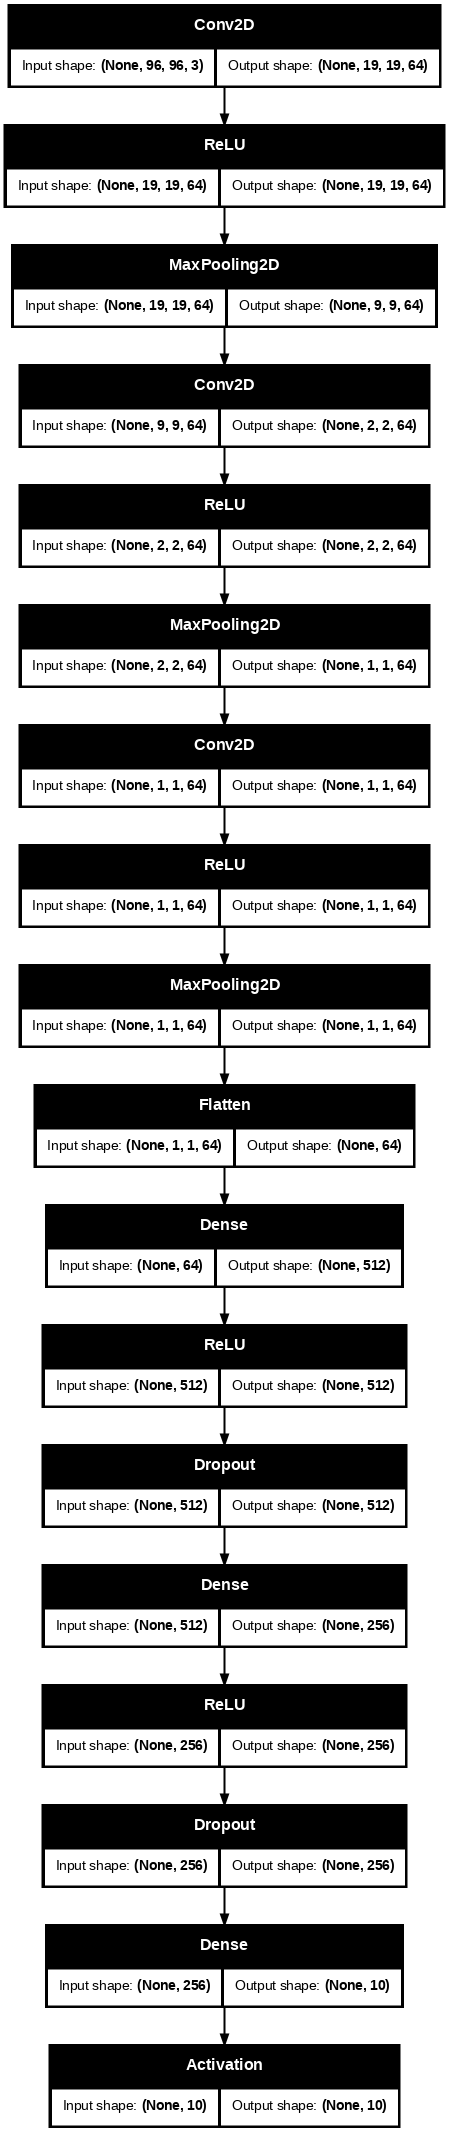

In [41]:
plot_model(model, to_file="model_3_scheme.png", show_layer_names=False, show_shapes=True, dpi=72)

Training: accuracy   = 0.998900 loss = 0.003045
Validation: accuracy = 0.984200 loss = 0.065979
Over fitting score   = 0.016582
Under fitting score  = 0.019307
Params count: 311434
stop epoch = 99
epochs = 100


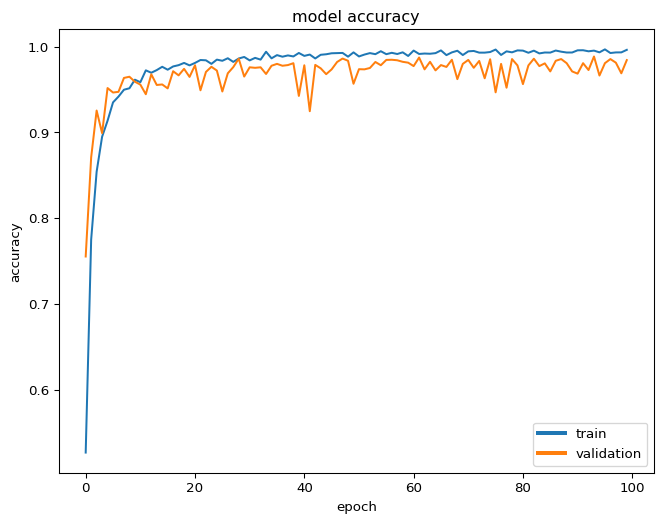

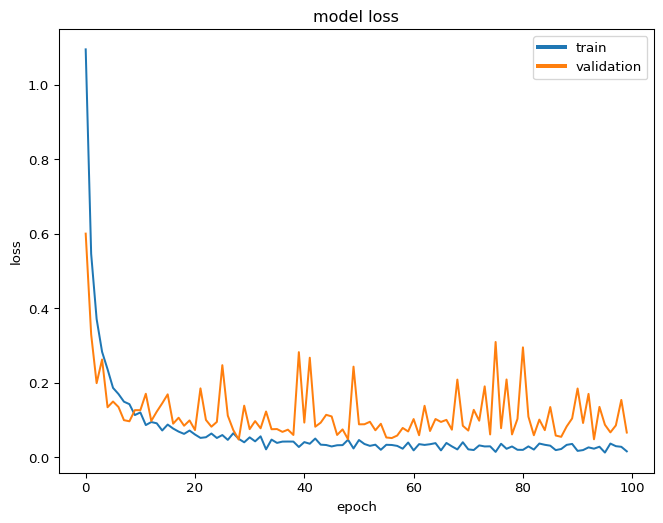

In [42]:
show_scores(model, hist, X_train, Y_train, X_test, Y_test)

In [8]:
loss, accuracy = model.evaluate(X_train, Y_train, verbose=0)
print("Training: accuracy = %f  ;  loss = %f" % (accuracy, loss))

Training: accuracy = 0.995300  ;  loss = 0.014116


In [9]:
loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print("Validation: accuracy = %f  ;  loss = %f" % (accuracy, loss))

Validation: accuracy = 0.975400  ;  loss = 0.124580


This is one of the very rare occasions in which our neural
network reached **100% training and validation accuracy!**
The second important point to bear in mind is that the number
of parameters in our neural network has dropped from 70 million to 1 million!
It means that with 1/70 of the size of our first model we were able to do much better.

This undoutably supports the claim that convolution and pooling layers are better fit for
image processing than usual Dense layers.

To gain full confidence in our model, we will test it on our two large data sets
figtab1.h5 and figtab2.h5 which contain 40K new samples.

In [12]:
check_data_set(model, "figtab1.h5")
check_data_set(model, "figtab2.h5")

Total num images in file: 10000
Load progress: 100%   
Time: 6.52 seconds
Loaded 10000 images
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9773 - loss: 0.1170
Data shape: (10000, 96, 96, 3)
accuracy = 0.977700 loss = 0.109667
Total num images in file: 10000
Load progress: 100%   
Time: 6.13 seconds
Loaded 10000 images
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9793 - loss: 0.0838
Data shape: (10000, 96, 96, 3)
accuracy = 0.978800 loss = 0.101393


(0.9787999987602234, 0.10139303654432297)

* Indeed, in both cases our model is achieving a very
  high accuracy score: 98.9% and 98.8%.
* This is a strong evidence for the validity and usefulness
  of our model when we apply it on
  new unknown samples.

* Let's take a look on some of very few cases in which it fails.

In [13]:
X1, y1, Y1, X2, y2, Y2 = load_data('figtab1.h5', 'figtab2.h5')
x_pred = model.predict(X2)
y_pred = np.argmax(x_pred, axis=1)

Loading training data set: figtab1.h5
Total num images in file: 10000
Load progress: 100%   
Time: 5.68 seconds
Loading validation data set: figtab2.h5
Total num images in file: 10000
Load progress: 100%   
Time: 5.81 seconds
10000 training samples
10000 validation samples
Image shape: (96, 96, 3)
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


In [14]:
true_preds = [(x,y) for (x,y,p) in zip(X2, y2, y_pred) if y == p]
false_preds = [(x,y,p) for (x,y,p) in zip(X2, y2, y_pred) if y != p]
print("Number of valid predictions: ", len(true_preds))
print("Number of invalid predictions:", len(false_preds))

Number of valid predictions:  9788
Number of invalid predictions: 212


* The array **false_preds** consists of all
  triples **(x,y,p)** where **x** is an image,
  **y** is its true class, and **p** is the false predicted value of **model**.
* We have only 212 failures from 10000 samples.
* Let's draw a sample of 15 of them

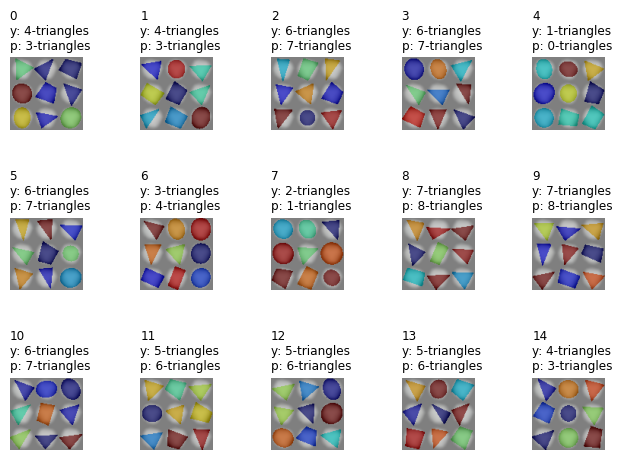

In [17]:
for i,(x,y,p) in enumerate(false_preds[0:15]):
    plt.subplot(3, 5, i+1)
    plt.imshow(0.5+0.5*x, cmap='jet')
    plt.title("%d\ny: %s\np: %s" % (i, class_name[y], class_name[p]), fontsize=9, loc='left')
    plt.axis('off')
    plt.subplots_adjust(wspace=0.8, hspace=0.3)

* We notice again that in all cases, the model missed the correct
  value by 1.
* An interesting question would be:
  can we build a Neural Network
  with a 100% accuracy level?
* Of course, it doesn't guarantee 100% success in future samples.
* The next model
  (due to [François Chollet](https://twitter.com/fchollet))
  looks like it.

## **Model 5 (François Chollet)**
* Next model algorithm is due to Google's Keras
  Engineer/Architect
  [François Chollet](https://twitter.com/fchollet).
  Copied from
  [his Keras/Tensorflow Guide](https://keras.io/examples/vision/image_classification_from_scratch)
* We copied it almost verbatim and it worked like a charm
  with an amazing result.
  Thanks François!

In [18]:
def make_model4(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)

    # Entry block
    #x = layers.Rescaling(1.0 / 255)(inputs)
    x = inputs
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    return tf.keras.Model(inputs, outputs)

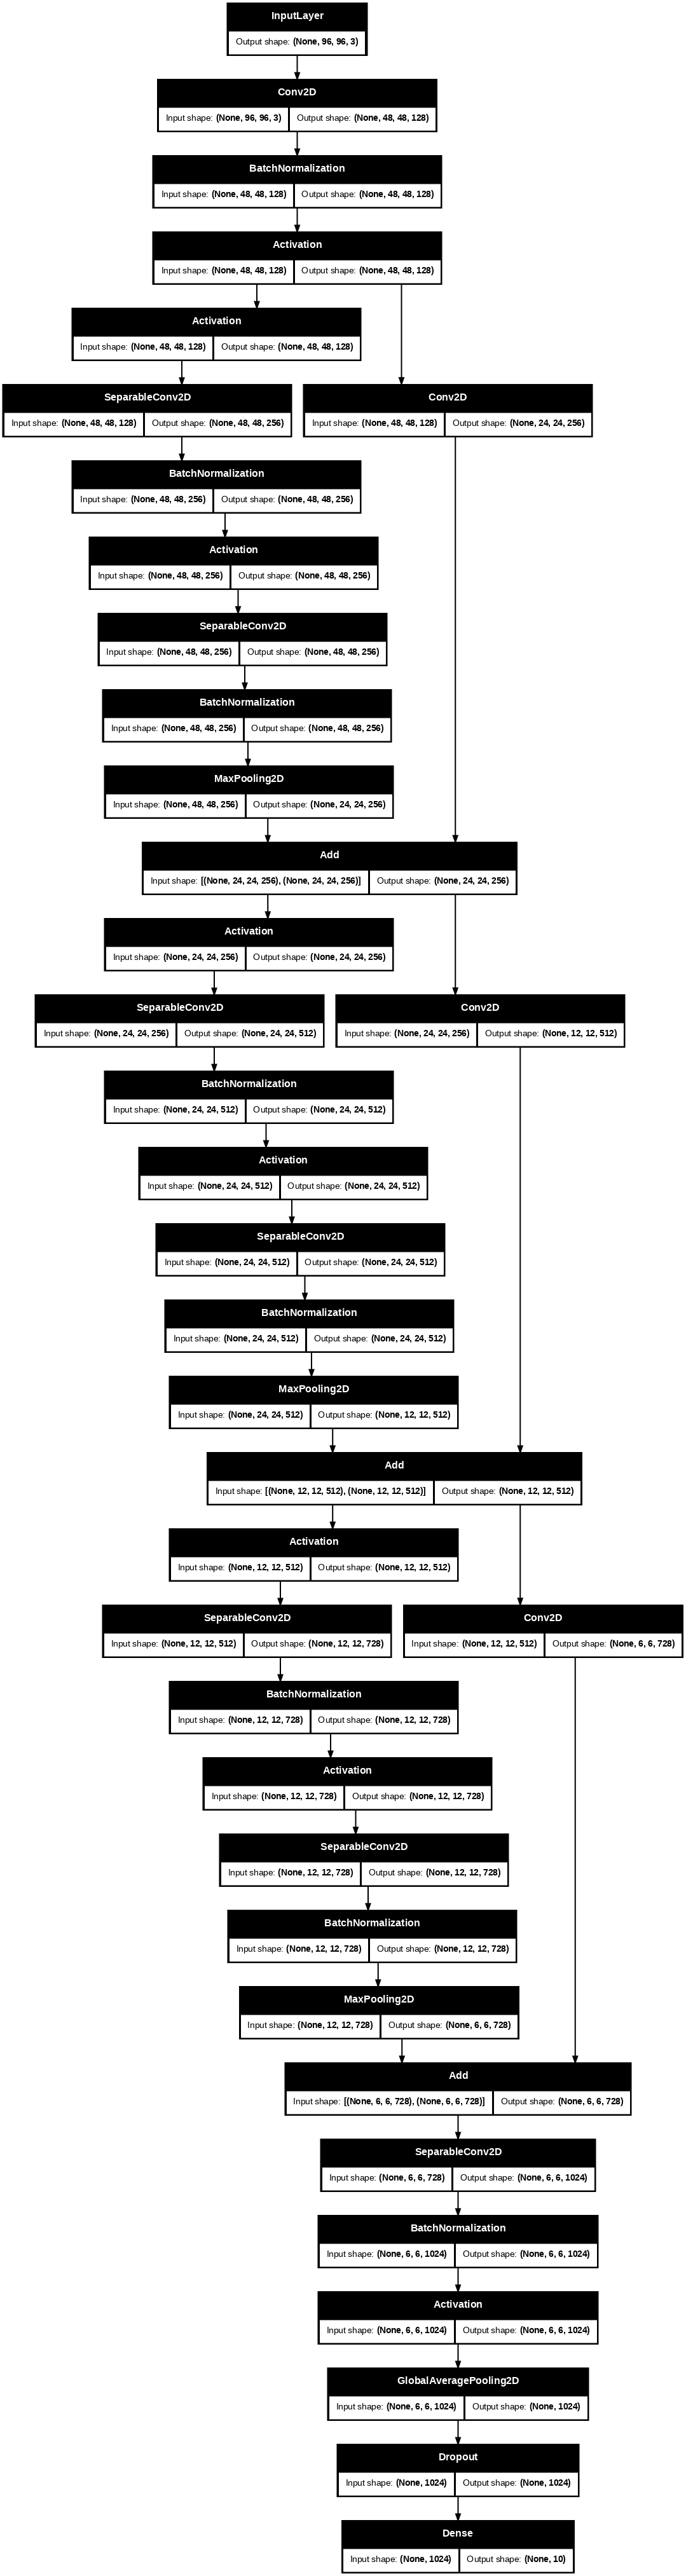

In [19]:
model = make_model4(input_shape=image_size + (3,), num_classes=num_classes)
plot_model(model, show_shapes=True, dpi=72)

### **Train the model**

In [20]:
epochs = 25

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]

model.compile(
    optimizer = tf.keras.optimizers.Adam(3e-4),
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics = [tf.keras.metrics.BinaryAccuracy(name="acc")],
)

hist = model.fit(
    X_train,
    Y_train,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = (X_test, Y_test),
)

Epoch 1/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 77s 88ms/step - acc: 0.9068 - loss: 0.2453 - val_acc: 0.8835 - val_loss: 0.5575
Epoch 2/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 61s 77ms/step - acc: 0.9303 - loss: 0.1323 - val_acc: 0.9397 - val_loss: 0.1116
Epoch 3/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 82s 77ms/step - acc: 0.9533 - loss: 0.0904 - val_acc: 0.9208 - val_loss: 0.1770
Epoch 4/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 47s 75ms/step - acc: 0.9701 - loss: 0.0650 - val_acc: 0.9866 - val_loss: 0.0382
Epoch 5/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 82s 74ms/step - acc: 0.9831 - loss: 0.0451 - val_acc: 0.9945 - val_loss: 0.0308
Epoch 6/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 81s 73ms/step - acc: 0.9936 - loss: 0.0259 - val_acc: 0.9953 - val_loss: 0.0208
Epoch 7/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 82s 73ms/step - acc: 0.9966 - loss: 0.0167 - val_acc: 0.9989 - val_loss: 0.0085
Epoch 8/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 49s 78ms/step - acc: 0.9985 - loss: 0.0100 - val_acc: 0.9993 - val_loss: 0.0086
Epoch 9/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 

Training: accuracy   = 0.999995 loss = 0.000117
Validation: accuracy = 1.000000 loss = 0.000159
Over fitting score   = 0.002348
Under fitting score  = 0.005722
Params count: 2740290
stop epoch = 24
epochs = 25


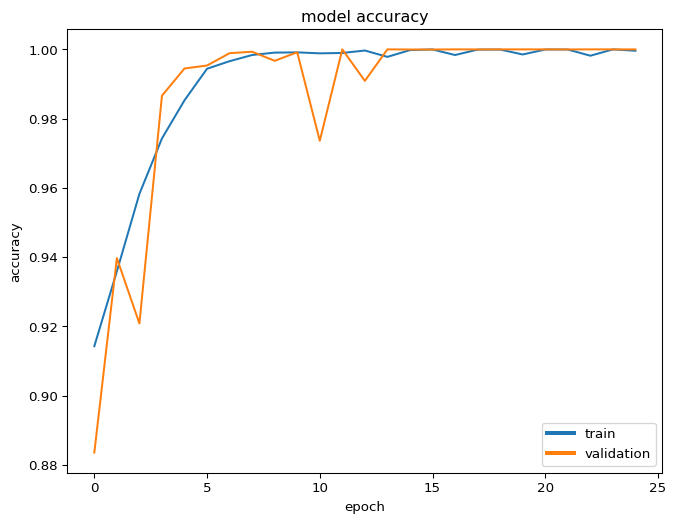

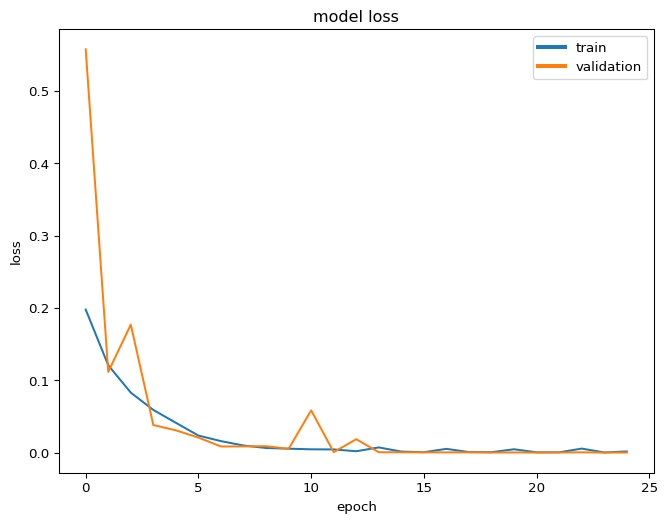

In [21]:
show_scores(model, hist, X_train, Y_train, X_test, Y_test)

In [22]:
loss, accuracy = model.evaluate(X_train, Y_train, verbose=0)
print("Training: accuracy = %f  ;  loss = %f" % (accuracy, loss))

Training: accuracy = 0.999995  ;  loss = 0.000117


In [23]:
loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print("Validation: accuracy1 = %f  ;  loss1 = %f" % (accuracy, loss))

Validation: accuracy1 = 1.000000  ;  loss1 = 0.000159


* Looks like this model achieves a 100% accuracy level!
* Let's test it on our auxiliary data sets.

In [24]:
check_data_set(model, "figtab1.h5")

Total num images in file: 10000
Load progress: 100%   
Time: 6.09 seconds
Loaded 10000 images
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - acc: 1.0000 - loss: 1.3731e-04
Data shape: (10000, 96, 96, 3)
accuracy = 1.000000 loss = 0.000143


(1.0, 0.00014259395538829267)

In [25]:
check_data_set(model, "figtab2.h5")

Total num images in file: 10000
Load progress: 100%   
Time: 6.32 seconds
Loaded 10000 images
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - acc: 1.0000 - loss: 1.4698e-04
Data shape: (10000, 96, 96, 3)
accuracy = 1.000000 loss = 0.000137


(1.0, 0.00013744640455115587)

In [26]:
check_data_set(model, "figtab3.h5")

Total num images in file: 10000
Load progress: 100%   
Time: 6.02 seconds
Loaded 10000 images
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - acc: 1.0000 - loss: 1.4181e-04
Data shape: (10000, 96, 96, 3)
accuracy = 1.000000 loss = 0.000141


(1.0, 0.0001407386444043368)

In [27]:
check_data_set(model, "figtab4.h5")

Total num images in file: 10000
Load progress: 100%   
Time: 5.97 seconds
Loaded 10000 images
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - acc: 1.0000 - loss: 1.4321e-04
Data shape: (10000, 96, 96, 3)
accuracy = 1.000000 loss = 0.000141


(1.0, 0.00014087666932027787)

* Looks like in all 4 cases the model
  achieved 100% success again.
* To be safe lets count individual samples.

In [28]:
X1, y1, Y1, X2, y2, Y2 = load_data('figtab1.h5', 'figtab2.h5')
x_pred = model.predict(X2)
y_pred = np.argmax(x_pred, axis=1)

Loading training data set: figtab1.h5
Total num images in file: 10000
Load progress: 100%   
Time: 6.60 seconds
Loading validation data set: figtab2.h5
Total num images in file: 10000
Load progress: 100%   
Time: 7.52 seconds
10000 training samples
10000 validation samples
Image shape: (96, 96, 3)
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step


In [29]:
true_preds = [(x,y) for (x,y,p) in zip(X2, y2, y_pred) if y == p]
false_preds = [(x,y,p) for (x,y,p) in zip(X2, y2, y_pred) if y != p]
print("Number of valid predictions: ", len(true_preds))
print("Number of invalid predictions:", len(false_preds))

Number of valid predictions:  10000
Number of invalid predictions: 0


In [30]:
X1, y1, Y1, X2, y2, Y2 = load_data('figtab3.h5', 'figtab4.h5')
x_pred = model.predict(X2)
y_pred = np.argmax(x_pred, axis=1)

true_preds = [(x,y) for (x,y,p) in zip(X2, y2, y_pred) if y == p]
false_preds = [(x,y,p) for (x,y,p) in zip(X2, y2, y_pred) if y != p]
print("Number of valid predictions: ", len(true_preds))
print("Number of invalid predictions:", len(false_preds))

Loading training data set: figtab3.h5
Total num images in file: 10000
Load progress: 100%   
Time: 7.24 seconds
Loading validation data set: figtab4.h5
Total num images in file: 10000
Load progress: 100%   
Time: 6.00 seconds
10000 training samples
10000 validation samples
Image shape: (96, 96, 3)
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step
Number of valid predictions:  10000
Number of invalid predictions: 0


* Looks like no failures at all! Indeed 100% accuracy.
* We will stop our experiments here and let you try to do better
  (good luck!): Can you preserve the 100% accuracy levels with a much smaller number of parameters?
* A smaller number of neurons and layers is also desirable.
* You can also experiment with other recognition tasks such
  as we mentioned above and see if they require different
  types of network complexity?